In [1]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import math
import numpy as np
import pandas as pd
import glob
import time

from sklearn import linear_model, model_selection, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from sklearn import model_selection, metrics
from scipy import stats # for statistical tests

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

plt.style.use('seaborn')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# Get the dataset
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Preprocessing Data

In [3]:
train = pd.read_pickle('gdrive/My Drive/sent_train.pkl')
train.head()

,index,feature,raw_clause,clause_vector,clause_polarity
0,154,review,Thank you for leaving a review,"[[-0.49886, 0.76602, 0.89751, -0.78547, -0.685...",0.00
0,154,dinner,\r\n\r\n Restaurant Ibid is now re - opened fo...,"[[-0.54264, 0.41476, 1.0322, -0.40244, 0.46691...",0.00
0,154,Mondays,\r\n\r\n Restaurant Ibid is now re - opened fo...,"[[-0.54264, 0.41476, 1.0322, -0.40244, 0.46691...",0.00
0,154,forwards,\r\n\r\n Looking forwards to hosting you,"[[0.29756, 0.70983, 0.65643, -1.3487, -0.41072...",0.00
0,154,reservations,reservations are highly recommended,"[[-0.13411, -0.39639, 0.64715, 0.38583, -0.225...",0.16


In [4]:
test = pd.read_pickle('gdrive/My Drive/sent_test.pkl')
test.head()

,index,feature,raw_clause,clause_vector,clause_polarity
0,176,burger,I have nt had such a delicious burger is a while,"[[0.15711, 0.65606, 0.0021149, -0.65144, -0.28...",0.5
0,176,while,I have nt had such a delicious burger is a while,"[[0.15711, 0.65606, 0.0021149, -0.65144, -0.28...",0.5
0,176,burgers,Great burgers at reasonable prices,"[[-0.42404, 0.0074403, -0.4665, -0.42496, -0.5...",0.5
0,176,prices,Great burgers at reasonable prices,"[[-0.42404, 0.0074403, -0.4665, -0.42496, -0.5...",0.5
0,176,Onion,Onion rings are crispy awesome too,"[[0.65609, 0.03754, -0.14359, -0.47495, 0.8703...",1.0


In [5]:
val = pd.read_pickle('gdrive/My Drive/sent_validate.pkl')
val.head()

,index,feature,raw_clause,clause_vector,clause_polarity
0,296,friends,Outdoor is kinda hot to chill with friends,"[[-0.54264, 0.41476, 1.0322, -0.40244, 0.46691...",0.25
0,296,Customer,Customer service good,"[[-0.4224, -0.13313, -0.41418, -0.23677, 0.190...",0.70
0,296,service,Customer service good,"[[-0.4224, -0.13313, -0.41418, -0.23677, 0.190...",0.70
0,112,review,Thank you for leaving a review,"[[-0.49886, 0.76602, 0.89751, -0.78547, -0.685...",0.00
0,112,dinner,\r\n\r\n Restaurant Ibid is now re - opened fo...,"[[-0.54264, 0.41476, 1.0322, -0.40244, 0.46691...",0.00


In [6]:
to_pred = pd.read_pickle('gdrive/My Drive/testing_sent_df.pkl')
to_pred.head()

,restaurant,stars,date,feat_index,index,feature,category,raw_clause,clause_vector,clause_polarity
0,Gravy_Restaurant,5 stars,2 days ago,0,There are lots of Indian restaurant at Tanjong...,lots,price,There are lots of Indian restaurant at Tanjong...,"[[-0.51533, 0.83186, 0.22457, -0.73865, 0.1871...",0.0
0,Gravy_Restaurant,5 stars,2 days ago,1,There are lots of Indian restaurant at Tanjong...,restaurant,ambience,There are lots of Indian restaurant at Tanjong...,"[[-0.51533, 0.83186, 0.22457, -0.73865, 0.1871...",0.0
0,Gravy_Restaurant,5 stars,2 days ago,2,There are lots of Indian restaurant at Tanjong...,time,price,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.0
0,Gravy_Restaurant,5 stars,2 days ago,3,There are lots of Indian restaurant at Tanjong...,dining,ambience,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.0
0,Gravy_Restaurant,5 stars,2 days ago,4,There are lots of Indian restaurant at Tanjong...,restrictions,price,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.0


In [7]:
to_pred2 = pd.read_pickle('gdrive/My Drive/reg_sent_df.pkl')
to_pred2.head()

,restaurant,stars,date,feat_index,index,feature,category,raw_clause,clause_vector,clause_polarity
0,Gravy_Restaurant,5 stars,4 days ago,0,There are lots of Indian restaurant at Tanjong...,lots,price,There are lots of Indian restaurant at Tanjong...,"[[-0.51533, 0.83186, 0.22457, -0.73865, 0.1871...",0.0
0,Gravy_Restaurant,5 stars,4 days ago,1,There are lots of Indian restaurant at Tanjong...,restaurant,ambience,There are lots of Indian restaurant at Tanjong...,"[[-0.51533, 0.83186, 0.22457, -0.73865, 0.1871...",0.0
0,Gravy_Restaurant,5 stars,4 days ago,2,There are lots of Indian restaurant at Tanjong...,time,price,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.0
0,Gravy_Restaurant,5 stars,4 days ago,3,There are lots of Indian restaurant at Tanjong...,dining,ambience,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.0
0,Gravy_Restaurant,5 stars,4 days ago,4,There are lots of Indian restaurant at Tanjong...,restrictions,price,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.0


In [8]:
to_pred2.shape

(6158, 10)

In [20]:
number_of_most_frequent_words=10000

In [11]:
X_train = train['raw_clause']
y_train = train['clause_polarity']

In [12]:
X_val = val['raw_clause']
y_val = val['clause_polarity']

In [13]:
X_test = test['raw_clause']
y_test= test['clause_polarity']

In [14]:
X_tp = to_pred['raw_clause']
y_tp = to_pred['clause_polarity']

In [15]:
X_tp2 = to_pred2['raw_clause']
y_tp2 = to_pred2['clause_polarity']

In [ ]:
X_train

0                       Thank you for leaving a review
0    \r\n\r\n Restaurant Ibid is now re - opened fo...
0    \r\n\r\n Restaurant Ibid is now re - opened fo...
0             \r\n\r\n Looking forwards to hosting you
0                  reservations are highly recommended
                           ...                        
0                                   Came in vegetarian
0                                           The sauces
0                   came out wanting to eat more steak
0                                          service and
0                                                sides
Name: raw_clause, Length: 8909, dtype: object

In [16]:
X_train = train['raw_clause'].to_numpy()
X_val = val['raw_clause'].to_numpy()
X_test = test['raw_clause'].to_numpy()
X_tp = to_pred['raw_clause'].to_numpy()
X_tp2 = to_pred2['raw_clause'].to_numpy()

# Tokenization and Padding

In [17]:
from keras.preprocessing.text import Tokenizer

In [18]:
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(X_train)

In [19]:
X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_val_tokens = tokenizer_obj.texts_to_sequences(X_val)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)
X_tp_tokens = tokenizer_obj.texts_to_sequences(X_tp)
X_tp2_tokens = tokenizer_obj.texts_to_sequences(X_tp2)

In [21]:
max_length = max([len(s.split()) for s in X_train])

In [22]:
vocab_size = len(tokenizer_obj.word_index) + 1

In [23]:
from keras.preprocessing.sequence import pad_sequences

In [24]:
X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')
X_tp_pad = pad_sequences(X_tp_tokens, maxlen=max_length, padding='post')
X_tp2_pad = pad_sequences(X_tp2_tokens, maxlen=max_length, padding='post')

# CNN Model

In [25]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [26]:
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr = 0.00001,verbose=1)
early = EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)

In [39]:
from tensorflow.keras import Sequential
from keras.layers import GRU,Embedding, Flatten, Conv1D, GlobalMaxPooling1D, Dropout, Dense, Input
import tensorflow as tf

EMBEDDING_DIM = 100
model = Sequential()
e = Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length)
model.add(e)
model.add(Conv1D(1024, 3, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam", metrics=[tf.keras.metrics.MeanSquaredError()])

hist = model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=100, batch_size=32, verbose=2, callbacks=[rlr, early])

Epoch 1/100
279/279 - 21s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - lr: 0.0010 - 21s/epoch - 74ms/step
Epoch 2/100
279/279 - 20s - loss: 0.0095 - mean_squared_error: 0.0095 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - lr: 0.0010 - 20s/epoch - 71ms/step
Epoch 3/100
279/279 - 20s - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - lr: 0.0010 - 20s/epoch - 71ms/step
Epoch 4/100
279/279 - 20s - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - lr: 0.0010 - 20s/epoch - 71ms/step
Epoch 5/100
279/279 - 20s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - lr: 0.0010 - 20s/epoch - 70ms/step
Epoch 6/100
279/279 - 20s - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - lr: 0.0010 - 20s/epoch - 71ms/step
Epoch 7/100
279/279 - 20s - loss: 0.0016 - mea

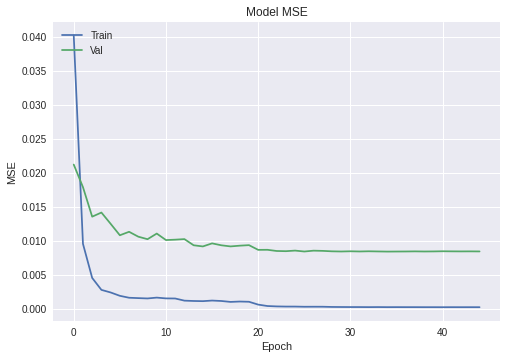

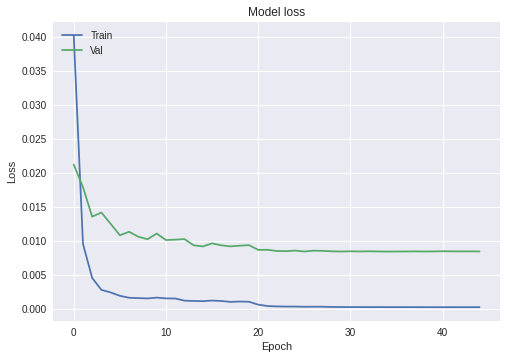

In [40]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

plt.plot(hist.history['mean_squared_error'])
plt.plot(hist.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [41]:
pred = model.predict(X_test_pad)

In [42]:
pred

array([[4.9570248e-01],
       [4.9570248e-01],
       [4.7128826e-01],
       ...,
       [4.2551011e-04],
       [4.2551011e-04],
       [4.2551011e-04]], dtype=float32)

In [43]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, pred)

0.010683452968932314

In [44]:
final = test['feature']

In [45]:
pred.flatten()

array([4.9570248e-01, 4.9570248e-01, 4.7128826e-01, ..., 4.2551011e-04,
       4.2551011e-04, 4.2551011e-04], dtype=float32)

In [46]:
final.to_numpy()

array(['burger', 'while', 'burgers', ..., 'couple', 'dozen', 'oysters'],
      dtype=object)

In [47]:
pred = pd.DataFrame(pred)
final = pd.DataFrame(final)

In [48]:
result4 = final

In [49]:
result4.index = pred.index

In [50]:
result4['pred'] = pred

In [51]:
result4

,feature,pred
0,burger,0.495702
1,while,0.495702
2,burgers,0.471288
3,prices,0.471288
4,Onion,0.947980
...,...,...
2973,service,0.998355
2974,porterhouse,0.001609
2975,couple,0.000426
2976,dozen,0.000426


In [52]:
y_test

0    0.5
0    0.5
0    0.5
0    0.5
0    1.0
    ... 
0    1.0
0    0.0
0    0.0
0    0.0
0    0.0
Name: clause_polarity, Length: 2978, dtype: float64

In [ ]:
from google.colab import files
result4.to_csv('preds4222.csv', index=False) 
files.download('preds4222.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
y_test.to_csv('ytest.csv', index=False) 
files.download('ytest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Predicting New Dataset 1

In [55]:
pred = model.predict(X_tp_pad)

In [56]:
pred

array([[-7.672012e-04],
       [-7.672012e-04],
       [ 2.247259e-03],
       ...,
       [ 2.873303e-01],
       [ 2.873303e-01],
       [ 7.921478e-01]], dtype=float32)

In [57]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_tp, pred)

0.009696514583749821

In [ ]:
final = to_pred['feature']

In [ ]:
pred.flatten()

array([-0.00453277, -0.00453277, -0.00480882, ...,  0.24750957,
        0.24750957,  0.7817584 ], dtype=float32)

In [ ]:
final.to_numpy()

array(['lots', 'restaurant', 'time', ..., 'tables', 'restaurant', 'menu'],
      dtype=object)

In [ ]:
pred = pd.DataFrame(pred)
final = pd.DataFrame(final)

In [ ]:
result_new = final

In [ ]:
result_new.index = pred.index

In [ ]:
result_new['pred'] = pred

In [ ]:
result_new

,feature,pred
0,lots,-0.004533
1,restaurant,-0.004533
2,time,-0.004809
3,dining,-0.004809
4,restrictions,-0.004809
...,...,...
4225,food,0.784040
4226,hospitality,0.247510
4227,tables,0.247510
4228,restaurant,0.247510


In [ ]:
y_tp

0    0.000000
0    0.000000
0    0.000000
0    0.000000
0    0.000000
       ...   
0    0.400000
0    0.333333
0    0.333333
0    0.333333
0    0.400000
Name: clause_polarity, Length: 4230, dtype: float64

In [ ]:
to_pred

,restaurant,stars,date,feat_index,index,feature,category,raw_clause,clause_vector,clause_polarity
0,Gravy_Restaurant,5 stars,2 days ago,0,There are lots of Indian restaurant at Tanjong...,lots,price,There are lots of Indian restaurant at Tanjong...,"[[-0.51533, 0.83186, 0.22457, -0.73865, 0.1871...",0.000000
0,Gravy_Restaurant,5 stars,2 days ago,1,There are lots of Indian restaurant at Tanjong...,restaurant,ambience,There are lots of Indian restaurant at Tanjong...,"[[-0.51533, 0.83186, 0.22457, -0.73865, 0.1871...",0.000000
0,Gravy_Restaurant,5 stars,2 days ago,2,There are lots of Indian restaurant at Tanjong...,time,price,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.000000
0,Gravy_Restaurant,5 stars,2 days ago,3,There are lots of Indian restaurant at Tanjong...,dining,ambience,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.000000
0,Gravy_Restaurant,5 stars,2 days ago,4,There are lots of Indian restaurant at Tanjong...,restrictions,price,Second time dining out since the dining restri...,"[[-0.024221, -0.034855, 0.3571, -0.02155, -0.5...",0.000000
...,...,...,...,...,...,...,...,...,...,...
0,Comida_Mexicana,1 star,4 years ago,0,Great Mexican food! Great hospitality within t...,food,food,Great Mexican food,"[[-0.16486, 0.91997, 0.22737, -0.49031, -0.001...",0.400000
0,Comida_Mexicana,1 star,4 years ago,1,Great Mexican food! Great hospitality within t...,hospitality,price,Great hospitality within the few tables availa...,"[[0.23471, 0.097874, 0.049255, 0.42204, -0.253...",0.333333
0,Comida_Mexicana,1 star,4 years ago,2,Great Mexican food! Great hospitality within t...,tables,ambience,Great hospitality within the few tables availa...,"[[0.23471, 0.097874, 0.049255, 0.42204, -0.253...",0.333333
0,Comida_Mexicana,1 star,4 years ago,3,Great Mexican food! Great hospitality within t...,restaurant,ambience,Great hospitality within the few tables availa...,"[[0.23471, 0.097874, 0.049255, 0.42204, -0.253...",0.333333


In [ ]:
place = to_pred['restaurant']
category = to_pred['category']

In [ ]:
place = pd.DataFrame(place)

In [ ]:
place.index = pred.index

In [ ]:
result_new['place'] = place

In [ ]:
category = pd.DataFrame(category)
category.index = pred.index
result_new['category'] = category

In [ ]:
result_new

,feature,pred,place,category
0,lots,-0.004533,Gravy_Restaurant,price
1,restaurant,-0.004533,Gravy_Restaurant,ambience
2,time,-0.004809,Gravy_Restaurant,price
3,dining,-0.004809,Gravy_Restaurant,ambience
4,restrictions,-0.004809,Gravy_Restaurant,price
...,...,...,...,...
4225,food,0.784040,Comida_Mexicana,food
4226,hospitality,0.247510,Comida_Mexicana,price
4227,tables,0.247510,Comida_Mexicana,ambience
4228,restaurant,0.247510,Comida_Mexicana,ambience


In [ ]:
from google.colab import files
result_new.to_csv('preds4222_newtest2.csv', index=False) 
files.download('preds4222_newtest2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
y_tp.to_csv('ynew.csv', index=False) 
files.download('ynew.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Predicting New Dataset 2

In [59]:
pred = model.predict(X_tp2_pad)

In [60]:
pred

array([[-0.0007672 ],
       [-0.0007672 ],
       [ 0.00224726],
       ...,
       [-0.12606025],
       [-0.12606025],
       [-0.02285392]], dtype=float32)

In [61]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_tp2, pred)

0.013386552201145197

In [62]:
final = to_pred2['feature']

In [63]:
pred.flatten()

array([-0.0007672 , -0.0007672 ,  0.00224726, ..., -0.12606025,
       -0.12606025, -0.02285392], dtype=float32)

In [64]:
final.to_numpy()

array(['lots', 'restaurant', 'time', ..., 'signboard', 'bit', 'entrance'],
      dtype=object)

In [65]:
pred = pd.DataFrame(pred)
final = pd.DataFrame(final)

In [66]:
result_new = final

In [67]:
result_new.index = pred.index

In [68]:
result_new['pred'] = pred

In [69]:
result_new

,feature,pred
0,lots,-0.000767
1,restaurant,-0.000767
2,time,0.002247
3,dining,0.002247
4,restrictions,0.002247
...,...,...
6153,month,0.447087
6154,restaurant,0.000315
6155,signboard,-0.126060
6156,bit,-0.126060


In [70]:
place = to_pred2['restaurant']
category = to_pred2['category']

In [71]:
place = pd.DataFrame(place)

In [72]:
place.index = pred.index

In [73]:
result_new['place'] = place

In [74]:
category = pd.DataFrame(category)
category.index = pred.index
result_new['category'] = category

In [75]:
result_new

,feature,pred,place,category
0,lots,-0.000767,Gravy_Restaurant,price
1,restaurant,-0.000767,Gravy_Restaurant,ambience
2,time,0.002247,Gravy_Restaurant,price
3,dining,0.002247,Gravy_Restaurant,ambience
4,restrictions,0.002247,Gravy_Restaurant,price
...,...,...,...,...
6153,month,0.447087,roots,price
6154,restaurant,0.000315,roots,ambience
6155,signboard,-0.126060,roots,ambience
6156,bit,-0.126060,roots,price


In [76]:
from google.colab import files
result_new.to_csv('preds4222_newtest3.csv', index=False) 
files.download('preds4222_newtest3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
from google.colab import files
y_tp2.to_csv('ynew3.csv', index=False) 
files.download('ynew3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>